In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets("../data/MNIST/", one_hot=True)

Extracting ../data/MNIST/train-images-idx3-ubyte.gz
Extracting ../data/MNIST/train-labels-idx1-ubyte.gz
Extracting ../data/MNIST/t10k-images-idx3-ubyte.gz
Extracting ../data/MNIST/t10k-labels-idx1-ubyte.gz


In [3]:
print("Training {}".format(len(data.train.labels)))
print("Test {}".format(len(data.test.labels)))

Training 55000
Test 10000


In [4]:
data.test.cls = np.array([label.argmax() for label in data.test.labels])

In [5]:
img_size = 28
img_size_flat = img_size * img_size
img_shape = (img_size, img_size)
num_classes = 10

In [6]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    plt.figure()
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

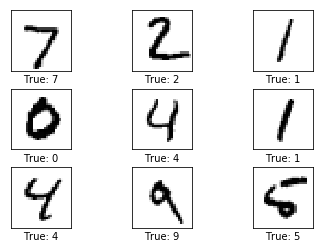

In [7]:
plot_images(images=data.test.images[0:9], cls_true=data.test.cls[0:9])

In [8]:
x = tf.placeholder(tf.float32, [None, img_size_flat])
y_true = tf.placeholder(tf.float32, [None, num_classes])
y_true_cls = tf.placeholder(tf.int64, [None])

weights = tf.Variable(tf.zeros([img_size_flat, num_classes]))
biases = tf.Variable(tf.zeros([num_classes]))

logits = tf.matmul(x, weights) + biases
y_pred = tf.nn.tanh(logits)
y_pred_cls = tf.argmax(y_pred, axis=1)

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits,
                                                        labels=y_true)

# cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits,
#                                                         labels=y_true)
cost = tf.reduce_mean(cross_entropy)
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.5).minimize(cost)
# optimizer = tf.train.AdamOptimizer(learning_rate=0.5).minimize(cost)
# optimizer = tf.train.AdagradOptimizer(learning_rate=0.5).minimize(cost)
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [9]:
session = tf.Session()
session.run(tf.global_variables_initializer())
batch_size = 100

In [10]:

def optimize(num_iterations, session):
    for i in range(num_iterations):
        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch = data.train.next_batch(batch_size)
        
        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        # Note that the placeholder for y_true_cls is not set
        # because it is not used during training.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)

In [11]:
feed_dict_test = {x: data.test.images,
                  y_true: data.test.labels,
                  y_true_cls: data.test.cls}
def print_accuracy(session):
    
    acc = session.run(accuracy, feed_dict=feed_dict_test)
    
    # Print the accuracy.
    print("Accuracy on test-set: {0:.1%}".format(acc))



In [12]:
def plot_example_errors(session):
    # Use TensorFlow to get a list of boolean values
    # whether each test-image has been correctly classified,
    # and a list for the predicted class of each image.
    correct, cls_pred = session.run([correct_prediction, y_pred_cls],
                                    feed_dict=feed_dict_test)

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.test.images[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.test.cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

In [13]:
def plot_weights(session):
    # Get the values for the weights from the TensorFlow variable.
    w = session.run(weights)
    
    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)

    # Create figure with 3x4 sub-plots,
    # where the last 2 sub-plots are unused.
    plt.figure()
    fig, axes = plt.subplots(3, 4)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Only use the weights for the first 10 sub-plots.
        if i<10:
            # Get the weights for the i'th digit and reshape it.
            # Note that w.shape == (img_size_flat, 10)
            image = w[:, i].reshape(img_shape)

            # Set the label for the sub-plot.
            ax.set_xlabel("Weights: {0}".format(i))

            # Plot the image.
            ax.imshow(image, vmin=w_min, vmax=w_max, cmap='seismic')

        # Remove ticks from each sub-plot.
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

Accuracy on test-set: 9.8%


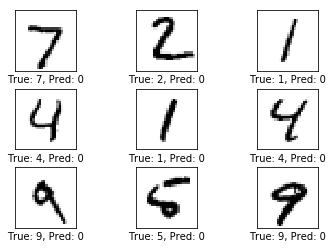

In [14]:
print_accuracy(session)
plot_example_errors(session)

Accuracy on test-set: 13.9%


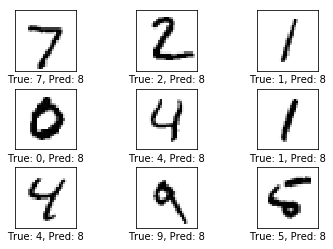

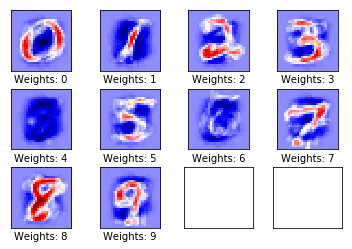

In [15]:
optimize(num_iterations=1,session=session)
print_accuracy(session)
plot_example_errors(session)
plot_weights(session)

Accuracy on test-set: 91.4%


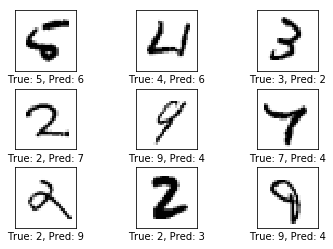

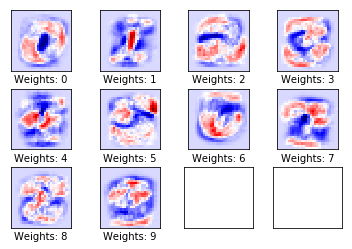

In [16]:
optimize(num_iterations=1600,session=session)
print_accuracy(session)
plot_example_errors(session)
plot_weights(session)

[[ 957    0    3    2    0    6   10    1    1    0]
 [   0 1108    2    2    1    2    4    2   14    0]
 [  13   10  922   11   10    5   14   12   31    4]
 [   3    1   36  855    0   63    4   16   24    8]
 [   1    2    4    1  929    0   11    2    8   24]
 [   8    2    5   18   10  797   17    4   26    5]
 [  14    3   10    1   12   14  900    2    2    0]
 [   2    8   25    4   10    1    0  947    2   29]
 [   9    6    7   11   10   52   13    8  852    6]
 [  11    5    1    5   59   11    0   28   12  877]]


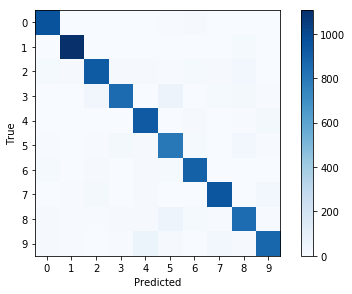

In [17]:
def print_confusion_matrix(session):
    # Get the true classifications for the test-set.
    cls_true = data.test.cls
    
    # Get the predicted classifications for the test-set.
    cls_pred = session.run(y_pred_cls, feed_dict=feed_dict_test)

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

    # Make various adjustments to the plot.
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
print_confusion_matrix(session)

In [18]:
# session.close()

* gda + softmax = Accuracy on test-set: 92.0%
* gda + sigmoid = Accuracy on test-set: 88.8%